# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### Start the Environment

In [1]:
import random
import torch
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent, ReplayBuffer

from unityagents import UnityEnvironment
import numpy as np


# Load Reacher env with 20 agents
env = UnityEnvironment(file_name='Reacher')

Mono path[0] = '/Users/soeren/Library/Mobile Documents/com~apple~CloudDocs/development/udacity/macmini/project2-reacher/Reacher.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/soeren/Library/Mobile Documents/com~apple~CloudDocs/development/udacity/macmini/project2-reacher/Reacher.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Some Helpers

In [4]:
def gather(env_info):
    rewards = env_info.rewards
    next_states = env_info.vector_observations
    dones = env_info.local_done
    return rewards, next_states, dones   

def print_status(agent, episode, scores, total_scores):
    avg100 = np.mean(np.array(total_scores).T[0][-100:])
    distance_info = f"dis: {np.mean(agent.distances[-1000:]):.3f} sclr: {agent.scalar:.5f}" if agent.noise_type == "param" else "" 
    print(f"Ep {episode}\tAvg100: {avg100:.2f}\tMean (min|max): {np.mean(scores):.2f} ({np.min(scores):.2f}|{np.max(scores):.2f}) {distance_info}")

def save(agent, noise_type):
    torch.save(agent.actor_regular.state_dict(), f'checkpoint_actor_{noise_type}.pth')
    torch.save(agent.critic_regular.state_dict(), f'checkpoint_critic_{noise_type}.pth')

def plot_scores(scores_array, labels, save_as=None):
    fig = plt.figure(figsize=(12,7))

    for scores, label in zip(scores_array, labels):
        scores = np.array(scores)
        if scores.ndim > 1:
            transposed = scores.T
            plt.plot(np.arange(1, len(scores)+1), transposed[0], label=label)
            plt.fill_between(np.arange(1, len(scores)+1), transposed[1], transposed[2], alpha=0.2)
        else:
            plt.plot(np.arange(1, len(scores)+1), scores, label=label)

    plt.axhline(y=30, color='green', linestyle='dashed')
    plt.axhline(y=37, color='lightgray', linestyle='dashed')
    plt.axhline(y=40, color='lightgray')

    plt.legend(loc='lower right')

    plt.ylabel('Score')
    plt.xlabel('Episode #')

    if save_as:
        plt.savefig(save_as)

    plt.show()

### Train the Agent with DDPG

In [5]:
def ddpg(n_episodes=150, max_t=1000, noise_type="normal"):
    
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]

    agent = Agent(state_size, action_size, noise_type=noise_type)
    
    print(agent)

    total_scores = []
    
    for episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        scores = np.zeros(num_agents)                           # initialize the score (for each agent)
        agent.reset()
        
        for _ in range(max_t):
            actions = agent.act(states)

            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            
            rewards, next_states, dones = gather(env_info)
            
            agent.step(states, actions, rewards, next_states, dones) # send actions to the agent
            
            scores += env_info.rewards                          # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            if np.any(dones):                                   # exit loop if episode finished
                break
    
        total_scores.append([np.mean(scores), np.min(scores), np.max(scores)])
        print_status(agent, episode, scores, total_scores)
        save(agent, noise_type)
    
    return total_scores




### Normal (Gauss) Action Noise


################################################################################

Hyperparameters: 

       state_size: 33
      action_size: 4
      random_seed: 0
       noise_type: normal
      learn_every: 16
          n_learn: 16
      alpha_actor: 0.001
     alpha_critic: 0.001
       batch_size: 256
      buffer_size: 1000000
            gamma: 0.99
              tau: 0.001
 desired_distance: 0.7
           scalar: 0.05
     scalar_decay: 0.99
    normal_scalar: 0.25

Actor(
  (seq): Sequential(
    (0): Linear(in_features=33, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=400, bias=True)
    (4): ReLU()
    (5): Linear(in_features=400, out_features=4, bias=True)
    (6): Tanh()
  )
)

Critic(
  (seq1): Sequential(
    (0): Linear(in_features=33, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_ru

Ep 124	Avg100: 34.51	Mean (min|max): 37.36 (28.49|39.61) 
Ep 125	Avg100: 34.75	Mean (min|max): 37.98 (35.80|39.59) 
Ep 126	Avg100: 35.01	Mean (min|max): 37.82 (33.82|39.68) 
Ep 127	Avg100: 35.24	Mean (min|max): 38.83 (37.67|39.50) 
Ep 128	Avg100: 35.47	Mean (min|max): 38.66 (35.54|39.69) 
Ep 129	Avg100: 35.68	Mean (min|max): 38.57 (36.70|39.55) 
Ep 130	Avg100: 35.90	Mean (min|max): 38.50 (34.34|39.62) 
Ep 131	Avg100: 36.12	Mean (min|max): 39.12 (37.40|39.66) 
Ep 132	Avg100: 36.33	Mean (min|max): 39.33 (38.49|39.57) 
Ep 133	Avg100: 36.50	Mean (min|max): 39.01 (37.60|39.66) 
Ep 134	Avg100: 36.68	Mean (min|max): 38.95 (36.44|39.63) 
Ep 135	Avg100: 36.83	Mean (min|max): 39.15 (37.97|39.65) 
Ep 136	Avg100: 36.95	Mean (min|max): 39.08 (37.84|39.64) 
Ep 137	Avg100: 37.08	Mean (min|max): 38.77 (35.69|39.57) 
Ep 138	Avg100: 37.20	Mean (min|max): 38.93 (35.89|39.55) 
Ep 139	Avg100: 37.30	Mean (min|max): 39.04 (37.13|39.55) 
Ep 140	Avg100: 37.42	Mean (min|max): 37.95 (34.41|39.54) 
Ep 141	Avg100:

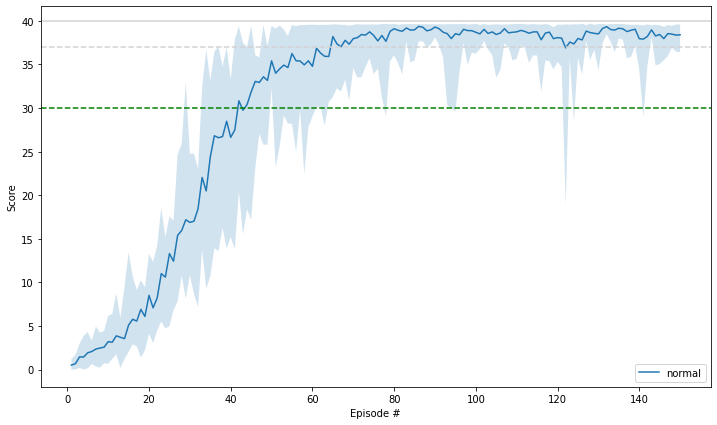

In [6]:
scores_normal = ddpg()
plot_scores([scores_normal], ['normal'], save_as='normal.png')

### Parameter Action Noise


################################################################################

Hyperparameters: 

       state_size: 33
      action_size: 4
      random_seed: 0
       noise_type: param
      learn_every: 16
          n_learn: 16
      alpha_actor: 0.001
     alpha_critic: 0.001
       batch_size: 256
      buffer_size: 1000000
            gamma: 0.99
              tau: 0.001
 desired_distance: 0.7
           scalar: 0.05
     scalar_decay: 0.99
    normal_scalar: 0.25

Actor(
  (seq): Sequential(
    (0): Linear(in_features=33, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=400, bias=True)
    (4): ReLU()
    (5): Linear(in_features=400, out_features=4, bias=True)
    (6): Tanh()
  )
)

Critic(
  (seq1): Sequential(
    (0): Linear(in_features=33, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_run

Ep 88	Avg100: 31.43	Mean (min|max): 38.18 (35.15|39.50) dis: 0.698 sclr: 0.07180
Ep 89	Avg100: 31.51	Mean (min|max): 38.91 (37.86|39.57) dis: 0.697 sclr: 0.07180
Ep 90	Avg100: 31.59	Mean (min|max): 38.87 (35.48|39.62) dis: 0.702 sclr: 0.06364
Ep 91	Avg100: 31.68	Mean (min|max): 39.24 (37.49|39.65) dis: 0.696 sclr: 0.06625
Ep 92	Avg100: 31.76	Mean (min|max): 39.24 (38.44|39.66) dis: 0.700 sclr: 0.06364
Ep 93	Avg100: 31.83	Mean (min|max): 38.91 (35.77|39.62) dis: 0.693 sclr: 0.06493
Ep 94	Avg100: 31.91	Mean (min|max): 39.13 (37.66|39.65) dis: 0.699 sclr: 0.06625
Ep 95	Avg100: 31.99	Mean (min|max): 38.93 (37.15|39.64) dis: 0.699 sclr: 0.06897
Ep 96	Avg100: 32.06	Mean (min|max): 38.69 (36.79|39.57) dis: 0.699 sclr: 0.06897
Ep 97	Avg100: 32.13	Mean (min|max): 39.05 (37.64|39.69) dis: 0.699 sclr: 0.06759
Ep 98	Avg100: 32.19	Mean (min|max): 38.58 (35.79|39.66) dis: 0.703 sclr: 0.06625
Ep 99	Avg100: 32.25	Mean (min|max): 38.25 (36.66|39.46) dis: 0.703 sclr: 0.06759
Ep 100	Avg100: 32.32	Mean (m

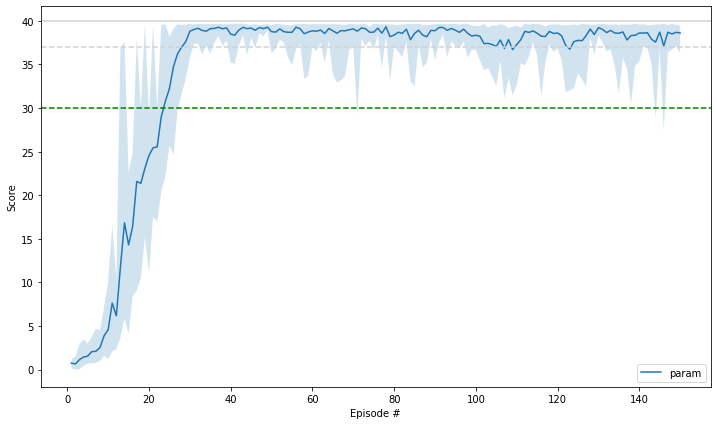

In [7]:
scores_param = ddpg(noise_type="param")
plot_scores([scores_param], ['param'], save_as='param.png')

### Ornstein–Uhlenbeck Process Action Noise


################################################################################

Hyperparameters: 

       state_size: 33
      action_size: 4
      random_seed: 0
       noise_type: ou
      learn_every: 16
          n_learn: 16
      alpha_actor: 0.001
     alpha_critic: 0.001
       batch_size: 256
      buffer_size: 1000000
            gamma: 0.99
              tau: 0.001
 desired_distance: 0.7
           scalar: 0.05
     scalar_decay: 0.99
    normal_scalar: 0.25

Actor(
  (seq): Sequential(
    (0): Linear(in_features=33, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=400, bias=True)
    (4): ReLU()
    (5): Linear(in_features=400, out_features=4, bias=True)
    (6): Tanh()
  )
)

Critic(
  (seq1): Sequential(
    (0): Linear(in_features=33, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_runnin

Ep 124	Avg100: 33.81	Mean (min|max): 37.26 (33.73|38.43) 
Ep 125	Avg100: 33.99	Mean (min|max): 35.73 (32.11|38.02) 
Ep 126	Avg100: 34.18	Mean (min|max): 37.45 (33.44|39.13) 
Ep 127	Avg100: 34.38	Mean (min|max): 37.29 (35.06|38.93) 
Ep 128	Avg100: 34.58	Mean (min|max): 37.86 (35.56|39.47) 
Ep 129	Avg100: 34.77	Mean (min|max): 37.87 (35.22|39.06) 
Ep 130	Avg100: 34.93	Mean (min|max): 37.30 (34.99|38.82) 
Ep 131	Avg100: 35.09	Mean (min|max): 37.55 (35.06|38.88) 
Ep 132	Avg100: 35.25	Mean (min|max): 37.41 (33.39|39.19) 
Ep 133	Avg100: 35.40	Mean (min|max): 37.45 (35.06|39.28) 
Ep 134	Avg100: 35.55	Mean (min|max): 36.46 (32.51|38.69) 
Ep 135	Avg100: 35.68	Mean (min|max): 34.63 (31.69|36.65) 
Ep 136	Avg100: 35.82	Mean (min|max): 37.87 (36.58|39.15) 
Ep 137	Avg100: 35.94	Mean (min|max): 37.03 (33.90|38.77) 
Ep 138	Avg100: 36.06	Mean (min|max): 36.35 (33.39|39.20) 
Ep 139	Avg100: 36.18	Mean (min|max): 37.54 (35.48|38.98) 
Ep 140	Avg100: 36.30	Mean (min|max): 36.66 (33.47|38.82) 
Ep 141	Avg100:

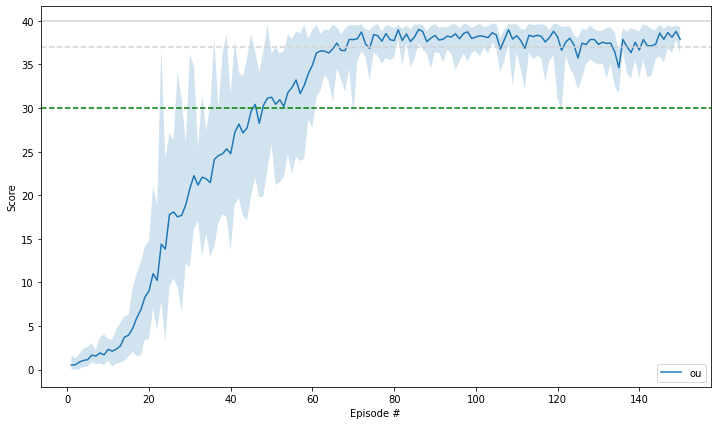

In [8]:
scores_ou = ddpg(noise_type="ou")
plot_scores([scores_ou], ['ou'], save_as='ou.png')

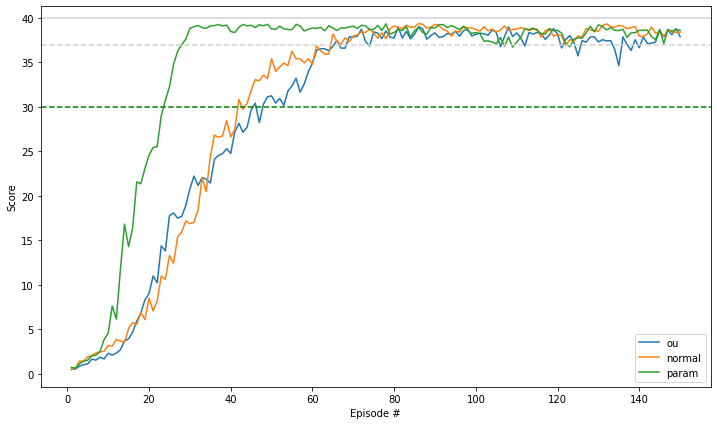

In [9]:
scores_normal_means = np.array(scores_normal).T[0]
scores_ou_means = np.array(scores_ou).T[0]
scores_param_means = np.array(scores_param).T[0]
plot_scores([scores_ou_means, scores_normal_means, scores_param_means], ['ou', 'normal', 'param'], save_as='compare.png')

In [10]:
env.close()